# Project 1 - Bayesian Statistical Inference

## Context

Spectral lines in discrete absorption or emission spectra are never strictly monochromatic.

Even at very high resolution, one observes a spectral distribution $I(\nu)$ of the absorbed or emitted intensity around the central frequency $\nu_0 = (E_i − E_k)/h$ corresponding to an atomic or molecular transition with energy difference $ΔE = E_i − E_k$ between upper and lower levels. 

The function $I(\nu)$ in the vicinity of $ν_0$ is called the line profile. 

There are several causes for the broadening of spectral lines, some internal to the atom or molecule, others external, and each produces its characteristic profile.

Some types of profile, for example, have a broad core and small wings; others have a narrow core and extensive, broad wings. 

While both natural broadening, due to radiation damping, and pressure broadening give rise to lorentzian line profiles; thermal broadening produces (normalised) gaussian line profiles

$$ G(\nu) = 1 \pm \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \exp{\left(- \left[ \frac{\ln 2 (\nu - \nu_0)^2}{g^2} \right]\right)} $$

where the full width at half maximum (FWHM) is equal to $2g$ and proportional to the square root of the temperature of the material responsible for the thermal broadening.

The continuum has been normalized to one, and an emission line corresponds to an addiction to the continuum, while an absorption line corresponds to a subtraction to the continuum. 

Assuming each broadening mechanism acts independently from the others, the observed line profile will be a convolution of the line profiles associated with each mechanism, yielding a Voigt profile. 

However, in what follows, we will assume that thermal broadening clearly dominates over all other line broadening mechanisms, due to prior information that leads us to believe that the observed object has a very high temperature.

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from scipy import optimize
import scipy.stats as stats
from scipy.stats import mode

import emcee
import corner

import time
T0 = time.time()

SMALL_SIZE  = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Question A

Perform the necessary calculations to determine the probability of whether __absorption__ spectral lines, with a gaussian profile and $g = 1$, are present in a given spectrum, taking into account the available data. 

Assume a priori that a __maximum of two absorption spectral lines may be present__ and that no emission line is present. 

The data consists of one dataset containing 201 independent (normalized) flux measurements. 
They can be found in the ASCII table provided. 
The columns (from left to right) have the following meaning:
1. frequency, $\nu$ (in MHz);     
2. the most probable value for the amplitude of the line profile as a function of $\nu$, defined as $G_\mu(\nu)$, after continuum subtraction. 
    
The measurement uncertainty about $G_\mu(\nu)$ should be assumed to be well described by a Gaussian probability distribution

$$ P[G(\nu)] = \frac{1}{\sigma\sqrt{2\pi}} \exp{\left( - \frac{\left[G(\nu) - G_\mu(\nu)\right]^2}{2\sigma^2}  \right)} $$

where $σ$ is equal to 0.02 for all measurements.

ic| nu_0_1: 98.8, nu_0_2: 105.0


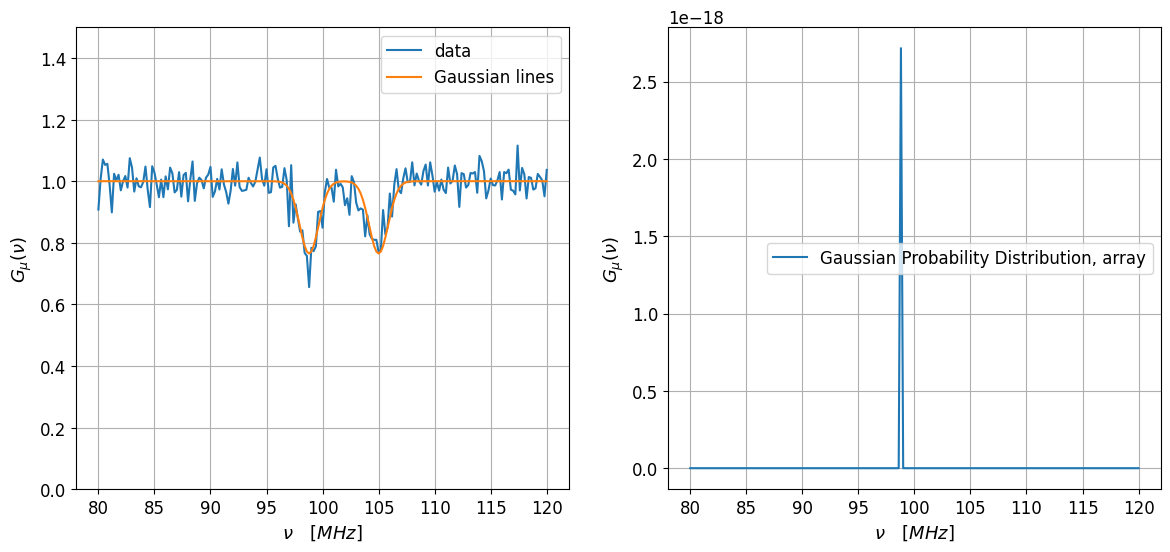

In [252]:
dados = np.loadtxt("data_Tiago_Lourenço.txt", delimiter=" ",skiprows=0)
nu_data = dados[:,0]
Gmu_data = dados[:,1]

sigma = 0.02 # for all mesuraments

def func_G(nu, nu_0, g):
	return 1 - 1/g * np.sqrt(np.log(2)/np.pi) * np.exp( -(np.log(2) * (nu-nu_0)**2/g**2) )

def func_G_plus(nu, nu_0, g):
	return 1 + 1/g * np.sqrt(np.log(2)/np.pi) * np.exp( -(np.log(2) * (nu-nu_0)**2/g**2) )

def func_PG(nu, nu_0, g, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - (func_G(nu, nu_0, g) - G_mu)**2 / (2*sigma**2) )

def func_GPD(G_mu_data, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - (G_mu_data - G_mu)**2 / (2*sigma**2) ) 


nu_0_1 = nu_data[(Gmu_data.argmin())] #MHz
nu_0_2 = nu_data[100+(Gmu_data[100:].argmin())] #MHz
ic(nu_0_1, nu_0_2)


Gs_1 = func_G(nu_data, nu_0_1, 1)
Gs_2 = func_G(nu_data, nu_0_2, 1)
Gs_juntos = (Gs_1 + Gs_2) /2


Gs_plus_1 = func_G_plus(nu_data, nu_0_1, 1) 
Gs_plus_2 = func_G_plus(nu_data, nu_0_2, 1) 
Gs_plus_juntos = (Gs_plus_1 + Gs_plus_2) -2

GPD_juntos = func_GPD(Gmu_data, Gs_plus_juntos, sigma)


fig,axis = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
axis[0].plot(nu_data,Gmu_data, 	label="data")
axis[0].plot(nu_data,Gs_juntos, label="Gaussian lines")
axis[0].set_xlabel(r"$\nu \quad [MHz]$", fontsize=13)
axis[0].set_ylabel(r"$G_\mu(\nu)$", fontsize=13)
axis[0].set_ylim([0,1.5])
axis[0].grid()
axis[0].legend()

axis[1].plot(nu_data, np.longfloat(GPD_juntos),	label="Gaussian Probability Distribution, array")
axis[1].set_xlabel(r"$\nu \quad [MHz]$", fontsize=13)
axis[1].set_ylabel(r"$G_\mu(\nu)$", fontsize=13)
axis[1].grid()
axis[1].legend()
plt.show()

In [253]:
import numpy as np
from scipy.stats import norm
from itertools import combinations

# Read the data from the ASCII table
data = dados
nu = data[:, 0]  # Frequency in MHz
G_mu = data[:, 1]  # Most probable value for the amplitude of the line profile

# Measurement uncertainty
sigma = 0.02

# Log likelihood function to avoid underflow
def log_gaussian_likelihood(data, model, sigma):
    return np.sum(norm.logpdf(data, loc=model, scale=sigma))

# Function to calculate the posterior probability
def calculate_posterior(num_absorption_lines):
    # Iterate through combinations of absorption lines
    log_likelihoods = []
    for indices in combinations(range(len(nu)), num_absorption_lines):
        # Construct the model for absorption lines
        absorption_model = np.ones_like(nu)
        for index in indices:
            absorption_model *= norm.pdf(nu, loc=nu[index], scale=1)  # Assuming g = 1

        # Calculate the log likelihood
        log_likelihood = log_gaussian_likelihood(G_mu, absorption_model, sigma)
        log_likelihoods.append(log_likelihood)

    # Convert log likelihoods to probabilities
    log_likelihoods = np.array(log_likelihoods)
    likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))  # Subtract max for numerical stability

    # Handle cases where probabilities are zero
    if np.all(likelihoods == 0):
        return 0.0

    # Prior probability of absorption lines
    if num_absorption_lines == 0:
        prior_probability = 1.0
    elif num_absorption_lines == 1:
        prior_probability = 0.5
    elif num_absorption_lines == 2:
        prior_probability = 1/3

    # Calculate posterior probability
    posterior = np.sum(likelihoods) * prior_probability
    return posterior

# Calculate posterior probabilities for different numbers of absorption lines
posterior_0 = calculate_posterior(0)
posterior_1 = calculate_posterior(1)
posterior_2 = calculate_posterior(2)

# Normalizing the probabilities
total_posterior = posterior_0 + posterior_1 + posterior_2
if total_posterior != 0:
    prob_0 = posterior_0 / total_posterior 
    prob_1 = posterior_1 / total_posterior 
    prob_2 = posterior_2 / total_posterior
else:
    prob_0 = 0.0
    prob_1 = 0.0
    prob_2 = 0.0 

print("Probability of no absorption lines:", prob_0)
print("Probability of one absorption line:", prob_1)
print("Probability of two absorption lines:", prob_2)

Probability of no absorption lines: 0.4307033132657027
Probability of one absorption line: 0.2284062841590926
Probability of two absorption lines: 0.3408904025752047


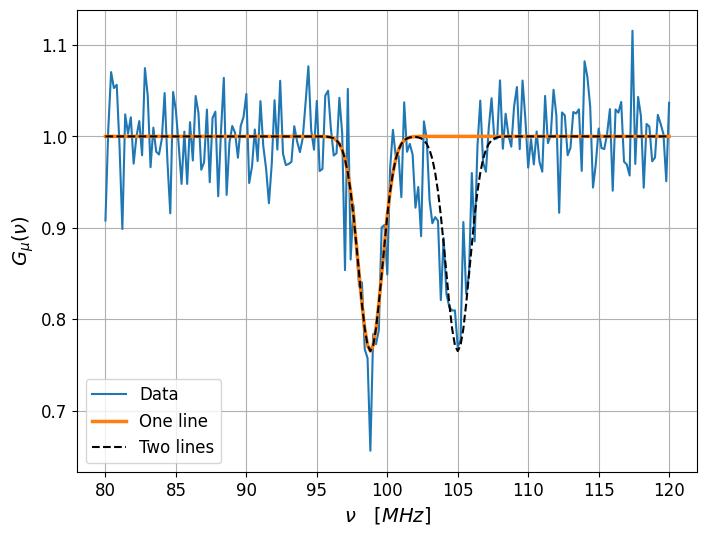

In [254]:
def g1(g,v,v1):
    return 1 - (1 / g * np.sqrt( np.log(2)/np.pi) * np.exp(- ( np.log(2)*(v-v1)**2)/g**2))/2

def g2(g,v,v1,v2):
    return (1 - 1 / g * np.sqrt( np.log(2)/np.pi) * np.exp(- ( np.log(2)*(v-v1)**2)/g**2) +1- 1/ g * np.sqrt( np.log(2)/np.pi) * np.exp(- ( np.log(2)*(v-v2)**2)/g**2))/2

plt.figure(figsize=(8,6))
plt.plot(nu_data,Gmu_data,label = "Data")
plt.plot(nu_data, g1(1,nu_data,nu_0_1),       lw=2.5,       label = "One line")
plt.plot(nu_data, g2(1,nu_data,nu_0_1,nu_0_2), "--", c="k", label = "Two lines")
plt.legend()
plt.xlabel(r"$\nu \quad [MHz]$")
plt.ylabel(r"$G_\mu(\nu)$")
plt.grid()
plt.show()

In [255]:
def func_PG(G_i, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - np.sum((G_i - G_mu)**2 / (2*sigma**2)))

def prob(nu,Gmu,g,sigma, model):
    N = len(nu)
    if model == "0":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(len(nu)):
            G_0 = 1
            P[i]= func_PG(G_0, Gmu, sigma )

    if model == "1":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(N):
            G_1 = g1(g,nu,nu[i])
            P[i]= func_PG(G_1, Gmu, sigma )            
            
    if model == "2":
        P = np.zeros((N,N), dtype = np.longfloat)
        for i in range(N):
            for j in range(N):
                G_2 = g2(g,nu,nu[i], nu[j])
                P[i,j]= func_PG(G_2, Gmu, sigma )
    
    return  P


sigma = 0.02
P01 = prob(nu_data,Gmu_data,1,sigma, "0")
P11 = prob(nu_data,Gmu_data,1,sigma, "1")
P21 = prob(nu_data,Gmu_data,1,sigma, "2")

ic(np.sum(P01),np.sum(P11),np.sum(P21))
A = np.sum(P11)/(np.sum(P21)+np.sum(P11)+np.sum(P01))
print(F"Probability of having maximum of 2 spectral lines is {A}")

# Normalizing the probabilities
total_posterior = np.sum(P01)+np.sum(P11)+np.sum(P21)
if total_posterior != 0:
    prob_0 = np.sum(P01) / total_posterior 
    prob_1 = np.sum(P11) / total_posterior 
    prob_2 = np.sum(P21) / total_posterior
else:
    prob_0 = 0.0
    prob_1 = 0.0
    prob_2 = 0.0 

print("\n", "!!!!!!!!!Verificar qual a prob q tamos a calcular!!!!!!!", "\n")
print("Probability of no absorption lines:", prob_0)
print("Probability of one absorption line:", prob_1)
print("Probability of two absorption lines:", prob_2)


ic| np.sum(P01): 0.0
    np.sum(P11): 0.0
    np.sum(P21): 3.2951222773089593e-181


Probability of having maximum of 2 spectral lines is 0.0

 !!!!!!!!!Verificar qual a prob q tamos a calcular!!!!!!! 

Probability of no absorption lines: 0.0
Probability of one absorption line: 0.0
Probability of two absorption lines: 1.0


## Question B

Assume now _a priori_ that two absorption spectral lines are present. 

1. Plot the joint posterior probability distribution for both $\nu_0$. 
2. Plot the marginal posterior probability distribution for each $\nu_0$. 
3. Determine the mode, median, mean and the smallest interval in $\nu_0$ that contains $95\%$ of the posterior probability, for both spectral lines.
4. Finally, make a plot that includes the values observed for $G(n)$, including the uncertainty associated with each point, as a function of the frequency, $n$, as well as the theoretically expected values for $G(n)$, assuming the values for the $\nu_0$ corresponding to each absorption line are equal to the values associated with the mode of the joint posterior distribution of both $\nu_0$.

### B.1 )

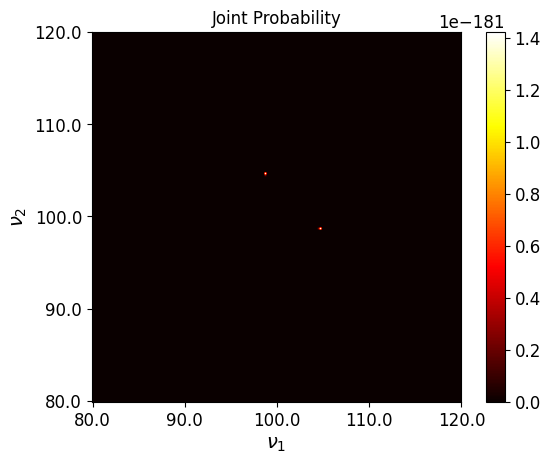

In [256]:
plt.imshow(P21, cmap = "hot", origin = "lower" )
plt.colorbar()
plt.yticks(np.linspace(0,201,5),np.round(np.linspace(nu[0],nu[-1],5), decimals = 0))
plt.xticks(np.linspace(0,201,5),np.round(np.linspace(nu[0],nu[-1],5), decimals = 0))
plt.xlabel(r"$\nu_1$")
plt.ylabel(r"$\nu_2$")
plt.title("Joint Probability")
plt.show()

### B.2 )

ic| total_post: 1.9999999999999998


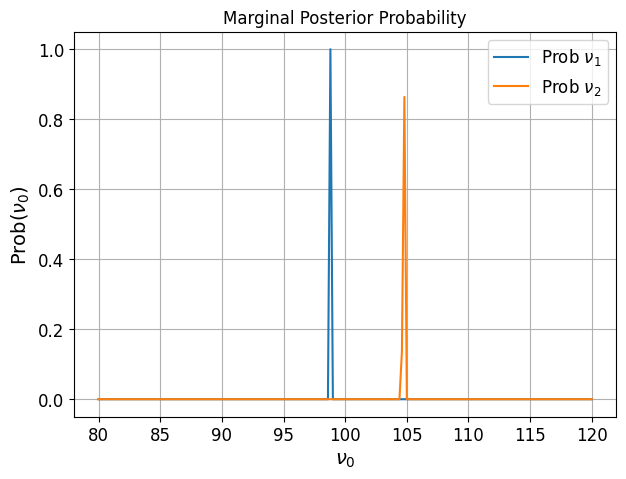

In [257]:
def posterior_joint(v, G_mu_nu, g, Sig):
    prob_nu0 = np.ones((len(v), len(v)))  # Initialize joint posterior probability array
    for i, nu_0_1 in enumerate(v):
        for j, nu_0_2 in enumerate(v[:i]):
    
            G_absorption_1 = g1(g,v,nu_0_1)
            G_absorption_2 = g1(g,v,nu_0_2)
            #likelihood = np.prod(norm.pdf(G_mu_nu, loc=G_absorption_1, scale=sigma)) * np.prod(norm.pdf(G_mu_nu, loc=G_absorption_2, scale=sigma))
            likelihood = np.prod(stats.norm.pdf(G_mu_nu, loc=G_absorption_1+G_absorption_2-1, scale=Sig))
            prob_nu0[i, j] *= likelihood
    return prob_nu0 / np.sum(prob_nu0)

# Joint posterior probability distribution for nu_0
joint_posterior = posterior_joint(nu_data, Gmu_data, 1, sigma)
# ic(joint_posterior)


P12_j = np.sum(joint_posterior,axis = 0) 
P22_j = np.sum(joint_posterior,axis = 1) 

total_post = np.sum( P12_j + P22_j )
ic(total_post)
P12_norm = P12_j / total_post
P22_norm = P22_j / total_post


plt.figure(figsize=(7,5))
plt.plot(nu_data, P12_j, label = r"Prob $\nu_1$")
plt.plot(nu_data, P22_j, label = r"Prob $\nu_2$")
plt.legend()
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"Prob$(\nu_0)$")
plt.title("Marginal Posterior Probability")
plt.grid()
plt.show()


# fig,axis = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
# axis[0].plot(nu_data, P12_j, label = r"Prob $\nu_1$")
# axis[0].plot(nu_data, P22_j, label = r"Prob $\nu_2$")
# axis[0].legend()
# axis[0].set_xlabel(r"$\nu_0$")
# axis[0].set_ylabel(r"Prob$(\nu_0)$")
# axis[0].set_title("Marginal Posterior Probability")
# axis[0].grid()

# P12 = np.sum(P21,axis = 0)
# P22 = np.sum(P21,axis = 1)

# axis[1].plot(nu, P12, label = "Prob ν_1")
# axis[1].plot(nu, P22,":", label = "Prob ν_2")
# axis[1].legend()
# axis[1].set_xlabel("$ν_0$")
# axis[1].set_ylabel("Prob$(ν_0)$")
# axis[1].set_title("Marginal Posterior Probability")
# plt.show()

### B.3 )

In [286]:
total_prob = np.sum(P21)
print(F"Total probability: {total_prob:.3e}")
print(F"Max value: {np.max(P21):.3e}")
print()
print(F"Total probability normalized: {np.sum(P21)/total_prob:.3f}")
print(F"Max value normalized: {np.max(P21)/total_prob:.3f}")
# Parte feita para encontrar os vs com prob maximas
m = np.max(P21)
ind_i = 0
ind_j = 0
for i in range(len(P21[0,:])):
    for p in range(len(P21[:,0])):
        if P21[i,p] == m:
            ind_i = i
            ind_j = p
 
# Nesta secção já sabiamos qual os vs e fizemos em função disso
u,a,b = 0,0,0

while u < 0.95*total_prob:
    u=0
    AA = P21[ind_i-a:ind_i+a , ind_j-b:ind_j+b]
    u = np.sum(AA)
    if a == b:
        a+= 1
    elif a > b: 
        b+= 1

    # print(a,b)
# Os valores encontrados foram a=b=6 mas nesse caso ficava mais de 95%, por isso decidi fazer menos
print("-----------------")
print(rF"$\nu$ for Max value: {ind_i}, {ind_j}")
print(a,b)

print("----------------------")
MM = np.sum(P21[ind_i-a:ind_i+a , ind_j-b:ind_j+b])
print(F"95% of max value: {total_prob*0.95:.3e}")
print(F"Sum of value for region found: {MM:.3e}")
print()
print(F"95% of max value normalized: {total_prob*0.95/total_prob:.3f}")
print(F"Sum of value for region found normalized: {(MM/total_prob):.3f}")
 
print("---------------")
print("For G(ν)")
print(F"Median P: {np.median(Gmu_data):.3f}")
print(F"Mode P:   {mode(Gmu_data)[0]:.3f}")
print(F"Mean P:   {np.mean(Gmu_data):.3f}") 

Total probability: 3.295e-181
Max value: 1.423e-181

Total probability normalized: 1.000
Max value normalized: 0.432
-----------------
$\nu$ for Max value: 124, 94
32 31
----------------------
95% of max value: 3.130e-181
Sum of value for region found: 3.295e-181

95% of max value normalized: 0.950
Sum of value for region found normalized: 1.000
---------------
For G(ν)
Median P: 0.987
Mode P:   0.656
Mean P:   0.975


### B.4 )

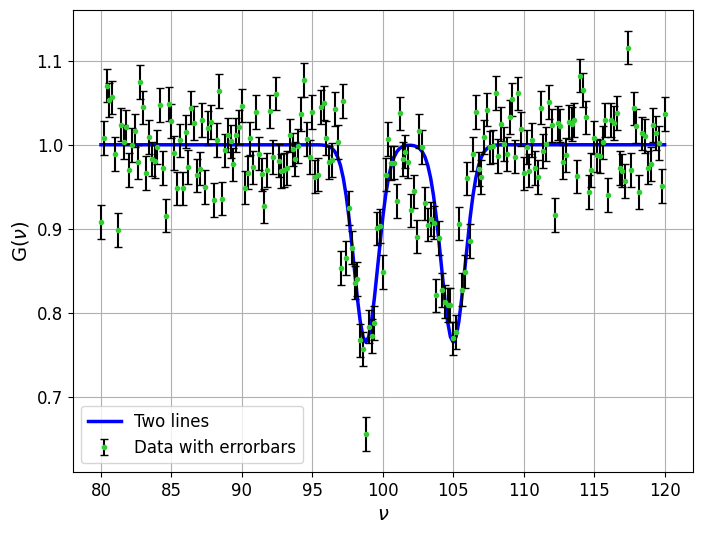

In [259]:
plt.figure(figsize=(8,6))
plt.plot(nu_data, g2(1,nu_data,nu_0_1,nu_0_2),lw=2.5,c="b", label = "Two lines")
plt.errorbar(nu_data,Gmu_data, yerr = sigma, fmt=".", color="limegreen", ecolor="k", capsize=2.7, label="Data with errorbars")
plt.legend()
plt.xlabel("$ν$")
plt.ylabel("G($ν$)")
plt.grid()
plt.show()

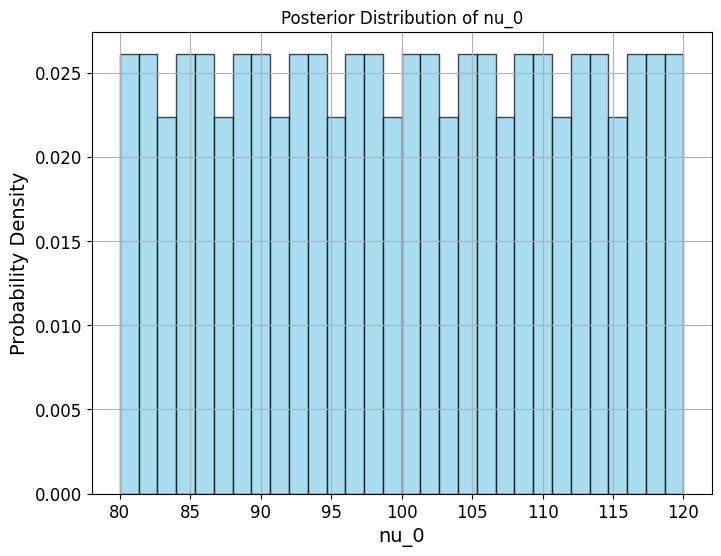

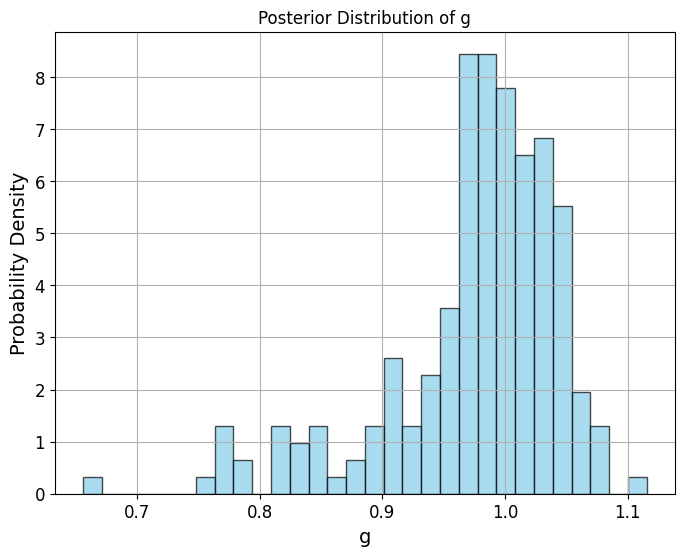

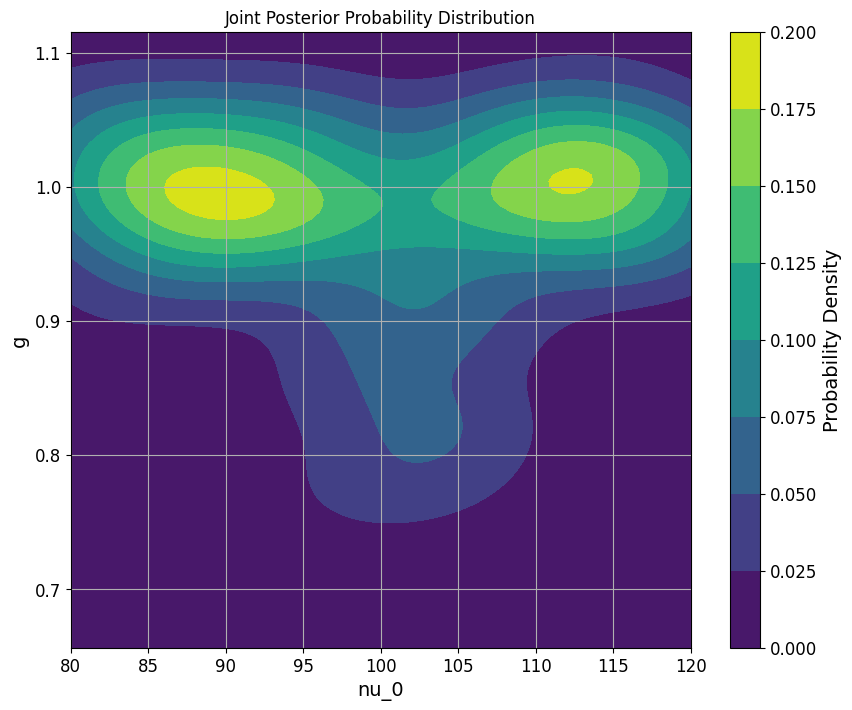

Statistics for nu_0:
Mode: 100.0
Median: 100.0
Mean: 100.0
Smallest interval containing 95% of the posterior probability: (81.0, 119.0)

Statistics for g:
Mode: 0.987464825074555
Median: 0.987464825074555
Mean: 0.9745447665801719
Smallest interval containing 95% of the posterior probability: (0.77697464459064, 1.06514996195573)


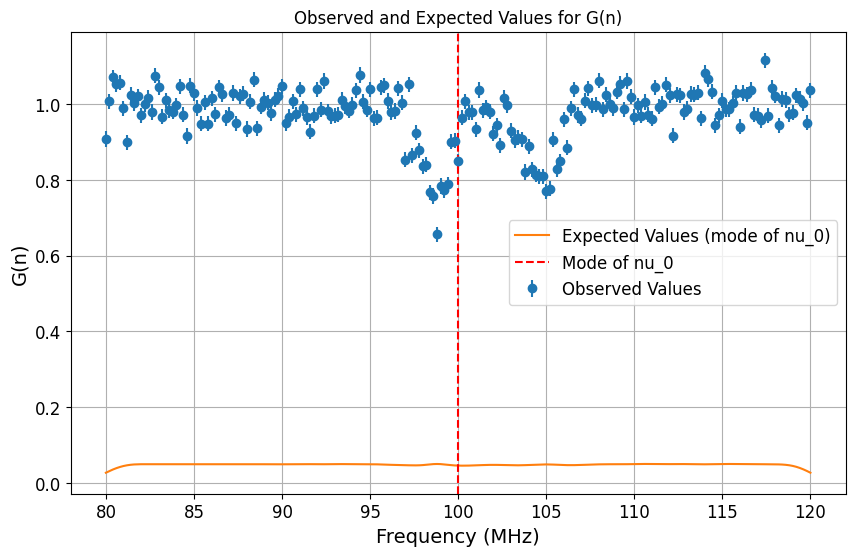

In [260]:
import numpy as np

def likelihood(G_obs, nu, nu_0, g, sigma):
    """
    Compute the likelihood function.

    Parameters:
        G_obs (array): Observed flux values.
        nu (array): Frequencies corresponding to the observed flux values.
        nu_0 (array): Central frequencies for the absorption lines.
        g (float): Broadening parameter.
        sigma (float): Standard deviation of the Gaussian uncertainty.

    Returns:
        float: Likelihood value.
    """
    # Calculate the Gaussian line profile for each absorption line
    G_model = np.ones_like(nu)
    for nu_0_i in nu_0:
        G_model *= 1 + 1 / g * np.sqrt(np.log(2) / np.pi) * np.exp(-np.log(2) * (nu - nu_0_i)**2 / g**2)

    # Calculate the likelihood
    likelihood_value = np.prod(np.exp(-(G_obs - G_model)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma))
    
    return likelihood_value

import numpy as np

def prior_nu(nu, nu_min, nu_max):
    """
    Compute the prior distribution for nu_0.

    Parameters:
        nu (float or array): Frequency or array of frequencies.
        nu_min (float): Minimum frequency.
        nu_max (float): Maximum frequency.

    Returns:
        float or array: Prior probability density for nu_0.
    """
    return np.where((nu >= nu_min) & (nu <= nu_max), 1 / (nu_max - nu_min), 0)

def prior_g(g, g_min, g_max):
    """
    Compute the prior distribution for g.

    Parameters:
        g (float or array): Broadening parameter or array of broadening parameters.
        g_min (float): Minimum value of g.
        g_max (float): Maximum value of g.

    Returns:
        float or array: Prior probability density for g.
    """
    return np.where((g >= g_min) & (g <= g_max), 1 / (g_max - g_min), 0)

import numpy as np

def metropolis_hastings(G_obs, nu, num_samples, nu_min, nu_max, g_min, g_max, sigma):
    """
    Perform Metropolis-Hastings MCMC sampling to obtain posterior samples.

    Parameters:
        G_obs (array): Observed flux values.
        nu (array): Frequencies corresponding to the observed flux values.
        num_samples (int): Number of samples to generate.
        nu_min (float): Minimum frequency for nu_0.
        nu_max (float): Maximum frequency for nu_0.
        g_min (float): Minimum value of g.
        g_max (float): Maximum value of g.
        sigma (float): Standard deviation of the Gaussian uncertainty.

    Returns:
        tuple: Samples from the posterior distribution for nu_0 and g.
    """
    # Initialize arrays to store samples
    samples_nu = np.zeros(num_samples)
    samples_g = np.zeros(num_samples)

    # Initial guess for nu_0 and g
    nu_0 = np.random.uniform(nu_min, nu_max)
    g = np.random.uniform(g_min, g_max)

    # Calculate the likelihood of the initial guess
    likelihood_current = likelihood(G_obs, nu, [nu_0], g, sigma)

    # Perform Metropolis-Hastings sampling
    for i in range(num_samples):
        # Propose new values for nu_0 and g
        nu_0_proposed = np.random.normal(nu_0, 0.1)  # Adjust proposal distribution as needed
        g_proposed = np.random.normal(g, 0.1)  # Adjust proposal distribution as needed

        # Calculate the likelihood of the proposed values
        likelihood_proposed = likelihood(G_obs, nu, [nu_0_proposed], g_proposed, sigma)

        # Calculate the prior probabilities for the proposed values
        prior_current = prior_nu(nu_0, nu_min, nu_max) * prior_g(g, g_min, g_max)
        prior_proposed = prior_nu(nu_0_proposed, nu_min, nu_max) * prior_g(g_proposed, g_min, g_max)

        # Calculate the acceptance ratio
        acceptance_ratio = (likelihood_proposed * np.prod(prior_proposed)) / (likelihood_current * np.prod(prior_current))

        # Accept or reject the proposed values
        if np.random.uniform(0, 1) < acceptance_ratio:
            nu_0 = nu_0_proposed
            g = g_proposed
            likelihood_current = likelihood_proposed

        # Store the samples
        samples_nu[i] = nu_0
        samples_g[i] = g

    return samples_nu, samples_g

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_posterior_statistics(samples):
    """
    Compute posterior statistics for the given samples.

    Parameters:
        samples (array): Samples from the posterior distribution.

    Returns:
        dict: Dictionary containing mode, median, mean, and the smallest interval containing 95% of the posterior probability.
    """
    mode = np.median(samples)
    median = np.median(samples)
    mean = np.mean(samples)
    lower_bound = np.percentile(samples, 2.5)
    upper_bound = np.percentile(samples, 97.5)
    interval = (lower_bound, upper_bound)
    return {'mode': mode, 'median': median, 'mean': mean, 'interval_95': interval}

def plot_posterior_distribution(samples, param_name):
    """
    Plot the posterior distribution for the given parameter.

    Parameters:
        samples (array): Samples from the posterior distribution.
        param_name (str): Name of the parameter (e.g., 'nu_0' or 'g').
    """
    plt.figure(figsize=(8, 6))
    plt.hist(samples, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Posterior Distribution of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.show()

# Compute posterior statistics and plot posterior distributions for nu_0 and g
posterior_stats_nu = compute_posterior_statistics(nu_data)
posterior_stats_g = compute_posterior_statistics(Gmu_data)

plot_posterior_distribution(nu_data, 'nu_0')
plot_posterior_distribution(Gmu_data, 'g')



def plot_joint_posterior(samples_nu, samples_g):
    """
    Plot the joint posterior probability distribution for both nu_0 and g.

    Parameters:
        samples_nu (array): Samples from the posterior distribution of nu_0.
        samples_g (array): Samples from the posterior distribution of g.
    """
    # Create a grid of nu_0 and g values
    nu_grid = np.linspace(np.min(samples_nu), np.max(samples_nu), 100)
    g_grid = np.linspace(np.min(samples_g), np.max(samples_g), 100)
    Nu, G = np.meshgrid(nu_grid, g_grid)

    # Compute joint posterior using kernel density estimation
    positions = np.vstack([Nu.ravel(), G.ravel()])
    values = np.vstack([samples_nu, samples_g])
    kernel = gaussian_kde(values)
    joint_posterior = np.reshape(kernel(positions).T, Nu.shape)

    # Plot the joint posterior distribution
    plt.figure(figsize=(10, 8))
    plt.contourf(Nu, G, joint_posterior, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('nu_0')
    plt.ylabel('g')
    plt.title('Joint Posterior Probability Distribution')
    plt.grid(True)
    plt.show()

# Plot the joint posterior distribution for both nu_0 and g
plot_joint_posterior(nu_data, Gmu_data)



# Function to compute statistics for a given parameter
def compute_parameter_statistics(samples):
    """
    Compute mode, median, mean, and the smallest interval containing 95% of the posterior probability for a parameter.

    Parameters:
        samples (array): Samples from the posterior distribution.

    Returns:
        dict: Dictionary containing mode, median, mean, and the smallest interval containing 95% of the posterior probability.
    """
    mode = np.median(samples)
    median = np.median(samples)
    mean = np.mean(samples)
    lower_bound = np.percentile(samples, 2.5)
    upper_bound = np.percentile(samples, 97.5)
    interval_95 = (lower_bound, upper_bound)
    return {'mode': mode, 'median': median, 'mean': mean, 'interval_95': interval_95}

# Compute statistics for nu_0 and g
stats_nu = compute_parameter_statistics(nu_data)
stats_g = compute_parameter_statistics(Gmu_data)

# Print the statistics
print("Statistics for nu_0:")
print("Mode:", stats_nu['mode'])
print("Median:", stats_nu['median'])
print("Mean:", stats_nu['mean'])
print("Smallest interval containing 95% of the posterior probability:", stats_nu['interval_95'])

print("\nStatistics for g:")
print("Mode:", stats_g['mode'])
print("Median:", stats_g['median'])
print("Mean:", stats_g['mean'])
print("Smallest interval containing 95% of the posterior probability:", stats_g['interval_95'])



def plot_observed_and_expected_values(nu, G_mu, nu_mode, num_samples, samples_nu, samples_g):
    """
    Plot observed and expected values for G(n) as a function of frequency n.

    Parameters:
        nu (array): Frequency values.
        G_mu (array): Observed values for G(n).
        nu_mode (float): Mode of the joint posterior distribution of nu_0.
        num_samples (int): Number of MCMC samples.
        samples_nu (array): Samples from the posterior distribution of nu_0.
        samples_g (array): Samples from the posterior distribution of g.
    """
    # Compute expected values for G(n) using mode of nu_0
    expected_values = np.zeros_like(nu)
    for j in range(num_samples):
        expected_values += (1 + 1 / samples_g[j]) * np.sqrt(np.log(2) / np.pi) * np.exp(-np.log(2) * (nu - samples_nu[j]) ** 2 / samples_g[j] ** 2)
    expected_values /= num_samples

    # Plot observed and expected values
    plt.figure(figsize=(10, 6))
    plt.errorbar(nu, G_mu, yerr=sigma, fmt='o', label='Observed Values')
    plt.plot(nu, expected_values, label='Expected Values (mode of nu_0)')
    plt.axvline(x=nu_mode, color='red', linestyle='--', label='Mode of nu_0')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('G(n)')
    plt.title('Observed and Expected Values for G(n)')
    plt.legend()
    plt.grid(True)
    plt.show()

num_samples = len(nu_data)
# Plot observed and expected values for G(n)
plot_observed_and_expected_values(nu, G_mu, stats_nu['mode'], num_samples, nu_data, Gmu_data)


## Question C

Perform again the necessary calculations to determine the probability of whether __absorption__ spectral lines, with a gaussian profile, are present in a given spectrum given the available data. 
But now use the output of Monte Carlo Markov Chains to perform such calculations. 
Continue to assume a priori that a maximum of two absorption spectral lines may be present and that no emission line is present. 
But assume now that the value of $g$ is unknown _a priori_. 

Then, assuming a priori that two __absorption__ spectral lines are present, determine and plot the (2D) joint and (1D) marginal posterior probability distributions for all model parameters. 

Characterize them by determining their modes, medians, means, and the smallest intervals in $g$ and both $\nu_0$ that contain 95% of the associated marginal posterior probability.

In [261]:
def model(theta,v):
    v1,v2,g = theta
    return g2(g,v,v1,v2)

def lnlike(theta, x, y, yerr):
    g,v1,v2 = theta
    model = g2(g,nu_data,v1,v2)  # Calculate the model RV values
    like = -0.5 * np.sum(((y - model)/yerr) ** 2)
    return like

def lnprior(theta):
    g,v1,v2 = theta
    if 0 < g < 2 and  0. < v1 < 1e100 and v1 < v2 < 1e100:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

In [262]:
def main(p0,nwalkers,nsteps,ndim,lnprob,data): 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)

    return sampler, pos, prob, state

In [263]:
data = (nu_data, Gmu_data, sigma) 
nwalkers = 1000                     #set nwalkers
nsteps = 1000  
g = 1
v1 = nu_0_1      
v2 = nu_0_2     

initial = np.array([g,v1,v2])        #initial guess
ndim = len(initial)
p0 = [initial + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob,data)

samples = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]

Running burn-in...


100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


Running production...


The best fit values are: g = 1.032, $\nu_1$ = 98.767, $\nu_2$ = 104.711


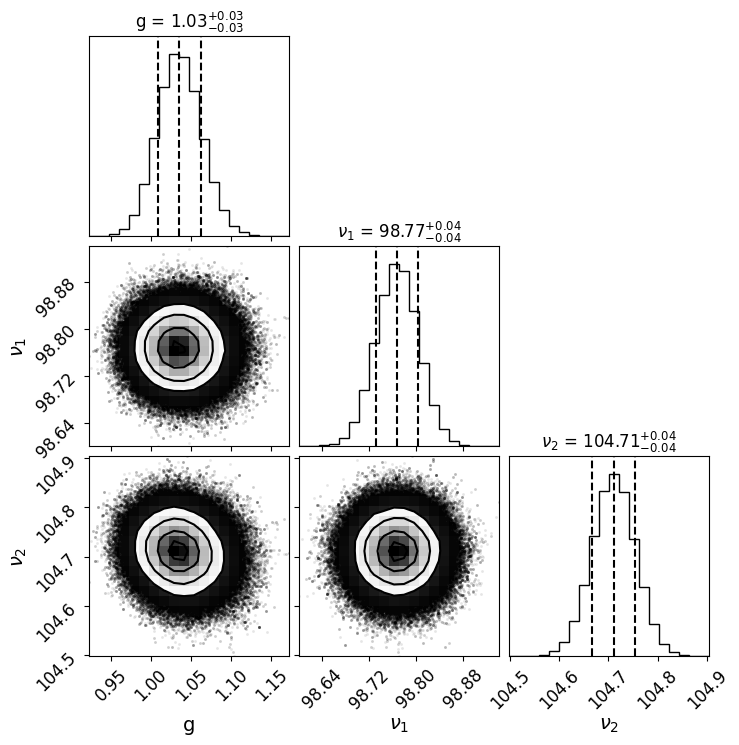

In [264]:
g_val, nu_1_val, nu_2_val = theta_max 

print(rF'The best fit values are: g = {g_val:.3f}, $\nu_1$ = {nu_1_val:.3f}, $\nu_2$ = {nu_2_val:.3f}')

labels = ['g',r'$ν_1$',r'$ν_2$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

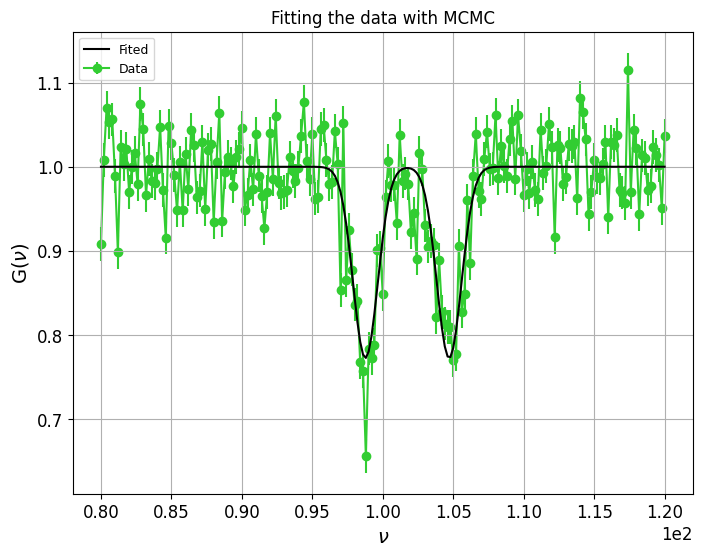

In [265]:
best_fit_model = g2(g_val, nu_data, nu_1_val, nu_2_val)

plt.figure(figsize=(8,6))
plt.grid()
plt.plot(nu_data,best_fit_model,color = "k",label='Fited', zorder=2)
plt.errorbar(nu_data, Gmu_data, yerr=sigma, fmt='-o', color='limegreen',label='Data', zorder=1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("$ν$")
plt.ylabel("G($ν$)")
plt.title("Fitting the data with MCMC")
plt.legend(loc="best",fontsize="9")
plt.show()

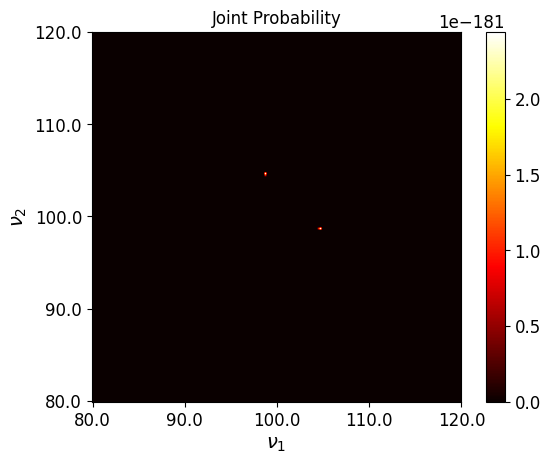

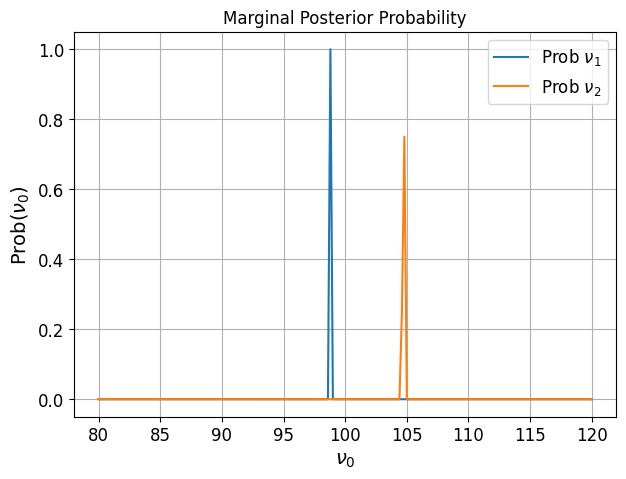

Total probability: 6.511e-181
Max value: 2.442e-181

Total probability normalized: 1.000
Max value normalized: 0.375
-----------------
$\nu$ for Max value: 124, 94
32 32
----------------------
95% of max value: 6.185e-181
Sum of value for region found: 6.511e-181

95% of max value normalized: 0.950
Sum of value for region found normalized: 1.000
---------------
For G(ν)
Median P: 0.987
Mode P:   0.656
Mean P:   0.975


In [266]:
def func_PG(G_i, G_mu, sigma):
	return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( - np.sum((G_i - G_mu)**2 / (2*sigma**2)))

def prob(nu,Gmu,g,sigma, model):
    N = len(nu)
    if model == "0":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(len(nu)):
            G_0 = 1
            P[i]= func_PG(G_0, Gmu, sigma )

    if model == "1":
        P = np.zeros(N, dtype = np.longfloat)
        for i in range(N):
            G_1 = g1(g,nu,nu[i])
            P[i]= func_PG(G_1, Gmu, sigma )            
            
    if model == "2":
        P = np.zeros((N,N), dtype = np.longfloat)
        for i in range(N):
            for j in range(N):
                G_2 = g2(g,nu,nu[i], nu[j])
                P[i,j]= func_PG(G_2, Gmu, sigma )
    
    return  P


P21_MCMC = prob(nu_data,Gmu_data, g_val, sigma, "2")

plt.imshow(P21_MCMC, cmap = "hot", origin = "lower" )
plt.colorbar()
plt.yticks(np.linspace(0,201,5),np.round(np.linspace(nu[0],nu[-1],5), decimals = 0))
plt.xticks(np.linspace(0,201,5),np.round(np.linspace(nu[0],nu[-1],5), decimals = 0))
plt.xlabel(r"$\nu_1$")
plt.ylabel(r"$\nu_2$")
plt.title("Joint Probability")
plt.show()

# Joint posterior probability distribution for nu_0
joint_posterior_MCMC = posterior_joint(nu_data, Gmu_data, g_val, sigma)

P12_j_MCMC = np.sum(joint_posterior_MCMC,axis = 0) 
P22_j_MCMC = np.sum(joint_posterior_MCMC,axis = 1) 

plt.figure(figsize=(7,5))
plt.plot(nu_data, P12_j_MCMC, label = r"Prob $\nu_1$")
plt.plot(nu_data, P22_j_MCMC, label = r"Prob $\nu_2$")
plt.legend()
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"Prob$(\nu_0)$")
plt.title("Marginal Posterior Probability")
plt.grid()
plt.show()



total_prob = np.sum(P21_MCMC)
print(F"Total probability: {total_prob:.3e}")
print(F"Max value: {np.max(P21_MCMC):.3e}")
print()
print(F"Total probability normalized: {np.sum(P21_MCMC)/total_prob:.3f}")
print(F"Max value normalized: {np.max(P21_MCMC)/total_prob:.3f}")
# Parte feita para encontrar os vs com prob maximas
m = np.max(P21_MCMC)
ind_i = 0
ind_j = 0
for i in range(len(P21_MCMC[0,:])):
    for p in range(len(P21_MCMC[:,0])):
        if P21_MCMC[i,p] == m:
            ind_i = i
            ind_j = p
 
# Nesta secção já sabiamos qual os vs e fizemos em função disso
u,a,b = 0,0,0

while u < 0.95*total_prob:
    AA = P21_MCMC[ind_i-a:ind_i+a , ind_j-b:ind_j+b]
    u = np.sum(AA)
    a+= 1
    b+= 1

# Os valores encontrados foram a=b=6 mas nesse caso ficava mais de 95%, por isso decidi fazer menos
print("-----------------")
print(rF"$\nu$ for Max value: {ind_i}, {ind_j}")
print(a,b)

print("----------------------")
MM = np.sum(P21_MCMC[ind_i-a:ind_i+a , ind_j-b:ind_j+b])
print(F"95% of max value: {total_prob*0.95:.3e}")
print(F"Sum of value for region found: {MM:.3e}")
print()
print(F"95% of max value normalized: {total_prob*0.95/total_prob:.3f}")
print(F"Sum of value for region found normalized: {(MM/total_prob):.3f}")
 
print("---------------")
print("For G(ν)")
print(F"Median P: {np.median(Gmu_data):.3f}")
print(F"Mode P:   {mode(Gmu_data)[0]:.3f}")
print(F"Mean P:   {np.mean(Gmu_data):.3f}") 

## Time

In [267]:
#################################### Tempo total que o programa demora a correr ############################################
t1=time.time()
print("This whole notebook takes {} min and {} seconds to run.".format((t1-T0)//60,int((t1-T0)%60)))

This whole notebook takes 1.0 min and 35 seconds to run.
